In [369]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [370]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('Bank Customer Churn Prediction.csv')
df.drop('customer_id', axis=1, inplace=True)

X = df.drop('churn', axis=1)
y = df['churn']

# Divide data into training and validation subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44, stratify=y)

df_train = X_train.join(y_train)    # 80% train set
df_test = X_test.join(y_test)       # 20% test set

In [371]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder

categorical_cols = ['country', 'gender', 'credit_card', 'active_member']
numerical_cols = ['credit_score',
                  'age',
                  'tenure',
                  'balance',
                  'products_number',
                  'estimated_salary']

preprocess = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols)
    ]
)

In [372]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, TomekLinks, ClusterCentroids, RepeatedEditedNearestNeighbours, EditedNearestNeighbours, AllKNN

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFpr, chi2
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    XGBClassifier()
]

over_samplers = SMOTE(sampling_strategy=0.75, k_neighbors=3)
under_samplers = [
    NearMiss(version=3, n_neighbors_ver3=3),
    TomekLinks(),
    ClusterCentroids(voting='hard'),
    RepeatedEditedNearestNeighbours(),
    EditedNearestNeighbours(),
    AllKNN()
]

reports = []
for model in models:
    for under_sampler in under_samplers:
        pipeline = Pipeline(steps=[
            ('preprocess', preprocess),
            ('over_sampler', over_samplers),
            ('under_sampler', under_sampler),
            ('selectior', SelectFpr(score_func=chi2, alpha=0.1)),
            ('reducer', StandardScaler()),
            (type(model).__name__, model)
        ], verbose=True)

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        reports.append((pipeline, '{}-{}'.format(type(model).__name__, type(under_sampler).__name__), classification_report(y_test, y_pred, output_dict=True), y_pred))

[Pipeline] ........ (step 1 of 5) Processing preprocess, total=   0.0s
[Pipeline] ..... (step 2 of 5) Processing under_sampler, total=   0.0s
[Pipeline] ......... (step 3 of 5) Processing selectior, total=   0.0s
[Pipeline] ........... (step 4 of 5) Processing reducer, total=   0.0s
[Pipeline]  (step 5 of 5) Processing DecisionTreeClassifier, total=   0.0s
[Pipeline] ........ (step 1 of 5) Processing preprocess, total=   0.0s
[Pipeline] ..... (step 2 of 5) Processing under_sampler, total=   0.1s
[Pipeline] ......... (step 3 of 5) Processing selectior, total=   0.0s
[Pipeline] ........... (step 4 of 5) Processing reducer, total=   0.0s
[Pipeline]  (step 5 of 5) Processing DecisionTreeClassifier, total=   0.0s
[Pipeline] ........ (step 1 of 5) Processing preprocess, total=   0.0s
[Pipeline] ..... (step 2 of 5) Processing under_sampler, total=   0.2s
[Pipeline] ......... (step 3 of 5) Processing selectior, total=   0.0s
[Pipeline] ........... (step 4 of 5) Processing reducer, total=   0.0

In [373]:
reports

[(Pipeline(steps=[('preprocess',
                   ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                    ['credit_score', 'age',
                                                     'tenure', 'balance',
                                                     'products_number',
                                                     'estimated_salary']),
                                                   ('cat', OrdinalEncoder(),
                                                    ['country', 'gender',
                                                     'credit_card',
                                                     'active_member'])])),
                  ('under_sampler', SMOTE(k_neighbors=3, sampling_strategy=0.75)),
                  ('selectior',
                   SelectFpr(alpha=0.1,
                             score_func=<function chi2 at 0x0000026584321EA0>)),
                  ('reducer', StandardScaler()),
                

In [374]:
df_eval = pd.DataFrame([[x[1], *[x[2]['0'][y] for y in x[2]['0']][:-1], *[x[2]['1'][y] for y in x[2]['0']][:-1], x[2]['weighted avg']['f1-score'], x[2]['accuracy']] for x in reports],
             columns=['Method', 'Class 0: Precision', 'Class 0: Recall', 'Class 0: F1-Score', 'Class 1: Precision', 'Class 1: Recall', 'Class 1: F1-Score', 'Weighted F1-Score', 'Accuracy Score']).round(2)
df_eval.sort_values(by=['Class 1: F1-Score'], ascending=False).reset_index(drop=True)

,Method,Class 0: Precision,Class 0: Recall,Class 0: F1-Score,Class 1: Precision,Class 1: Recall,Class 1: F1-Score,Weighted F1-Score,Accuracy Score
0,XGBClassifier-EditedNearestNeighbours,0.91,0.86,0.89,0.55,0.67,0.61,0.83,0.82
1,SVC-EditedNearestNeighbours,0.90,0.89,0.90,0.59,0.61,0.60,0.84,0.83
2,SVC-SMOTE,0.91,0.87,0.89,0.56,0.65,0.60,0.83,0.83
3,XGBClassifier-SMOTE,0.89,0.93,0.91,0.66,0.55,0.60,0.84,0.85
4,RandomForestClassifier-EditedNearestNeighbours,0.90,0.86,0.88,0.54,0.63,0.58,0.82,0.82
5,RandomForestClassifier-AllKNN,0.91,0.82,0.86,0.50,0.69,0.58,0.81,0.80
6,XGBClassifier-TomekLinks,0.88,0.94,0.91,0.68,0.51,0.58,0.84,0.85
7,SVC-AllKNN,0.91,0.85,0.88,0.52,0.65,0.58,0.82,0.81
8,XGBClassifier-AllKNN,0.91,0.82,0.87,0.50,0.70,0.58,0.81,0.80
9,RandomForestClassifier-TomekLinks,0.88,0.93,0.90,0.64,0.51,0.57,0.84,0.84


In [379]:
query = ['Class 1: F1-Score']
df_eval['Model'] = df_eval['Method'].str.split('-').str[0]

sorted_df = df_eval.groupby('Model').apply(lambda x: x.sort_values(by=query, ascending=False), include_groups=False)
results = sorted_df.iloc[::7].reset_index(level=0).index
sorted_df.iloc[::7].reset_index(level=0)[['Method', 'Class 1: Precision', 'Class 1: Recall', 'Weighted F1-Score', 'Accuracy Score']]

,Method,Class 1: Precision,Class 1: Recall,Weighted F1-Score,Accuracy Score
5,DecisionTreeClassifier-EditedNearestNeighbours,0.50,0.66,0.80,0.80
13,RandomForestClassifier-AllKNN,0.50,0.69,0.81,0.80
14,SVC-SMOTE,0.56,0.65,0.83,0.83
26,XGBClassifier-EditedNearestNeighbours,0.55,0.67,0.83,0.82


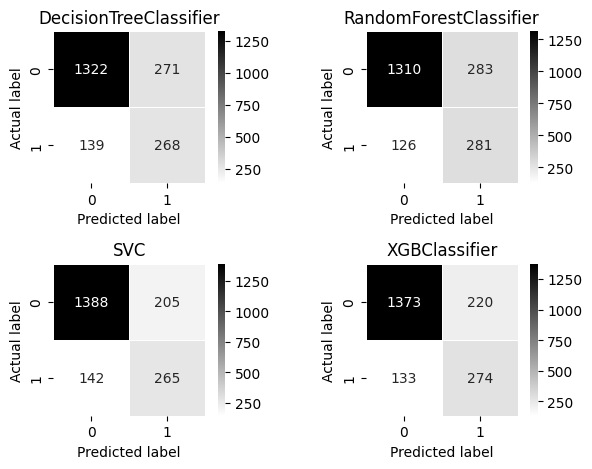

In [382]:
from sklearn.metrics import confusion_matrix

top_5_y_preds = [(reports[x][1], reports[x][3]) for x in results]

half = len(top_5_y_preds) // 2
fig, axs = plt.subplots(nrows=(half * 2 // half), ncols=half) #, figsize=(15, 10))
axs = axs.flat

for idx, y_pred in enumerate(top_5_y_preds):
    cm = confusion_matrix(y_test, y_pred[1])
    sns.heatmap(data=cm, linewidths=.5, annot=True, square=True, cmap='binary', fmt='.0f', ax=axs[idx])
    axs[idx].set_ylabel('Actual label')
    axs[idx].set_xlabel('Predicted label')
    axs[idx].set_title('{}'.format(y_pred[0].split('-')[0]))

plt.tight_layout()
plt.show()